# E12_
### 루브릭
1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.
- 데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.
2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.
- 적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.
3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.
- 3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.

## Step 1. 데이터의 전처리

In [1]:
import datetime as dt
from pathlib import Path
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

### data load

In [2]:
# data path
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

# 시간이 좀 걸릴 수 있습니다. 메모리도 10GB 가까이 소요될 수 있으니 메모리 상태에 주의해야 합니다.
data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [3]:
# 추천시스템을 구축할 때 가장 먼저 확인해 볼 것은 유저수(세션 수)와 아이템 수 
data['UserId'].nunique(), data['ItemId'].nunique(), data['Time'].nunique()
# UserId의 숫자가 약 6천 개, 아이템 숫자는 약 3.7천 개
# 같은 유저가 여러 개의 세션을 만들수도 있기 때문에 유저의 수가 6천명이라는 것은 아니다

(6040, 3706, 458455)

- UserId와 time 정보를 이용해 SessionId 열을 생성한다. 

In [4]:
# UserId와 Time을 기준으로 새로운 데이터프레임 생성
df = data.groupby(['UserId', 'Time'])['ItemId'].count().reset_index()
df.reset_index(inplace=True)
df

,index,UserId,Time,ItemId
0,0,1,978300019,1
1,1,1,978300055,3
2,2,1,978300103,1
3,3,1,978300172,1
4,4,1,978300275,1
...,...,...,...,...
471158,471158,6040,997454398,1
471159,471159,6040,997454429,1
471160,471160,6040,997454464,2
471161,471161,6040,997454486,1


In [5]:
data = pd.merge(data, df, on=['UserId', 'Time'])
data.drop(columns='ItemId_y', inplace=True)
data.columns = ['UserId', 'ItemId', 'Rating', 'Time', 'SessionId']
data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,978300019,0
1,1,1270,5,978300055,1
2,1,1721,4,978300055,1
3,1,1022,5,978300055,1
4,1,2340,3,978300103,2
...,...,...,...,...,...
1000204,6040,2917,4,997454429,471159
1000205,6040,1921,4,997454464,471160
1000206,6040,1784,3,997454464,471160
1000207,6040,161,3,997454486,471161


###  Session Length
각 세션은 대략 몇 개의 클릭 데이터를 갖을까?

In [6]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
0         1
1         3
2         1
3         1
4         1
         ..
471158    1
471159    1
471160    2
471161    1
471162    1
Length: 471163, dtype: int64

- session_length(표면적 의미): SessionId를 공유하는 데이터 row의 개수
- SessionId: 라우저에서 웹서버로 접속할 때 항상 포함하게 되는 유저 구분자
아까 로그인하지 않으면 사용자가 누군지 알 수 없다고 했었다. SessionId의 수가 사용자의 수와 1대1 대응하지 않는다는 것인데, 
그렇다면 SessionId를 기준으로 모아서 분류하는 것의 의미가 무엇일까? 그래도 최소한 특정 사용자의 행동을 SessionId 기준으로 모아서 분류해낼 수는 있다는 의미가 있다.
- session_length(실질적 의미): 해당 세션의 사용자가 그 세션 동안 몇번의 액션을 취했는지(몇개의 상품정보를 클릭했는지)의 의미

##### session_ length의 parameter들

In [7]:
session_length.median(), session_length.mean()

(2.0, 2.1228513274599234)

- median: 통계집단의 변량을 크기의 순서로 늘여놓았을 때, 중앙에 위치하는 값
- mean: 평균

In [8]:
# 최소, 최대값
session_length.min(), session_length.max()

(1, 30)

In [9]:
# 백분위수
session_length.quantile(0.999)

10.0

- pandas 함수명은 quantile( )   
pandas의 quantile함수의 q(백분위수)는 0과 1사이 값을 입력
- numpy 함수명은 percentile( )입니다.   
numpy의 percentile함수의 q(백분위수)는 0과 100사이 값을 입력

- 중앙값을 구할때 quantile( ) q값을 0.5, percentile( ) q값을 50으로 입력   

그런데 99.9% 세션은 길이가 10인데 세션의 최대 길이가 30인 이유는 뭘까?
99.9%의 사람들이 10이하로 클릭했는데 한 세션이 30번 클릭했다는 것은 뭔가 꺼림직하다.
 혹시 조작은 아닌지 의심할 필요가 있다. 음원 사재기 이런 경우도 이런식으로 확인해보면 좋을 것 같다.

In [10]:
long_session = session_length[session_length==30].index[0]
data[data['SessionId']==long_session]

,UserId,ItemId,Rating,Time,SessionId
112347,731,3044,4,975528402,55117
112348,731,1455,3,975528402,55117
112349,731,1639,5,975528402,55117
112350,731,3244,4,975528402,55117
112351,731,1656,2,975528402,55117
112352,731,3426,4,975528402,55117
112353,731,1829,2,975528402,55117
112354,731,2675,4,975528402,55117
112355,731,802,3,975528402,55117
112356,731,803,5,975528402,55117


##### session length가 max인 사용자의 클릭 정보 보자
만약 동일한 ItemId에 max SessionId 사용자가 클릭했으면 조작인 것을 확인할 수 있었겠지만, 표를 봐서 계속 다른 ItemId에 클릭한 걸로 봐선,조작이 아니었음을 알 수 있다. 또한 rating 정보를 보면 5점자리 평점의 영화 위주로 본 것은 아니지만, 그래도 대부분은 평점이 3이상의 영화를 클릭해보았다. 또한 평점 1점짜리 영화는 클릭하지 않았다는 것을 통해, 조작을 하기 위해 클릭을 했다기보다는 순전히 많은 영화들이 궁금했던 것 같다. 하지만 2이상 5이하의 정보들을 골고루 클릭한 것을 보아 그냥 무작위로 클릭을 해보았을 가능성이 있다. 따라서, 시각화할 때 Session length가 30인 정보는 빼고 시각화하기로 한다. 
## 시각화
#### 세션길이 기준 하위 99.9%까지의 분포 누적합을 시각화

In [11]:
# 변수 설정
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1    0.480048
2    0.713936
3    0.847350
4    0.919684
5    0.958639
6    0.979132
7    0.989772
8    0.994989
9    0.997604
dtype: float64

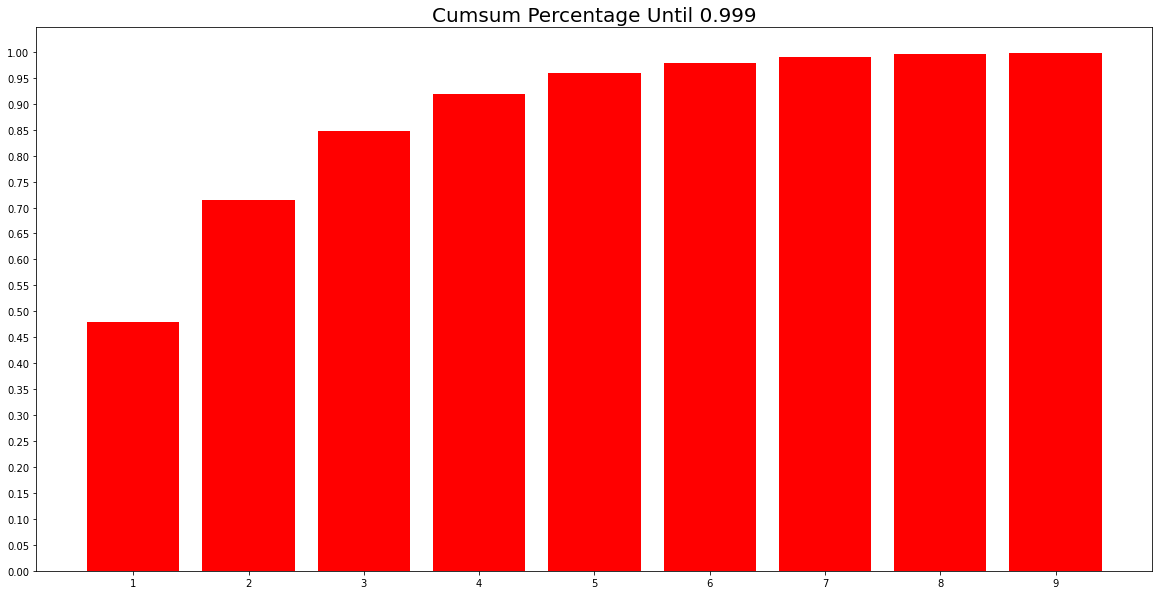

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

#### Matrix Factorization
- 추천시스템은 유저-상품 관계 매트릭스를 유저 행렬과 상품 행렬의 곱으로 표현한다.
- Q: 이 데이터도 유저와 클릭한 상품정보 관계에 대해 Matrix Factorization을 사용하면 어떨까?
- A: User * Item Matrix의 빈칸이 너무 많아서(data sparsity) 모델이 제대로 학습되지 않을 가능성이 있다.   
이 세션정보는 유저를 ID 기반으로 정리할 수 없기 때문에 세션 하나를 유저 하나로 본다면 기존의 유저-상품정보 Matrix보다 훨씬 sparse한 형태가 된다.

### Session Time
접속하는 시간대(오전, 오후, 새벽), 접속해 있는 시간, 접속하는 요일, 계절, 마지막 접속 시간, 장바구니에 넣고 지난 시간 등등
추천시스템을 구축할 때에는 최근 소비 트렌드를 학습하는 것이 중요하므로 이번에는 데이터가 발생한 시간에 대해 알아보자

In [13]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

956703932
1046454590


데이터 설명대로 3년치 데이터가 있는데 최근 트렌드를 파악하기 위해 1년치 데이터만 사용하려고 한다.   
1년치 데이터를 사용하면 성능이 더 좋아질까?

In [14]:
type(latest)
# latest는 Timestamp 객체이기 때문에 int 객체와의 사칙연산을 지원하지 않는다.
# 날짜끼리의 차이를 구하고 싶을 때는 datetime 라이브러리의 timedelta 객체를 사용한다.

numpy.int64

In [15]:
print(dt.datetime.utcfromtimestamp(oldest).strftime('%Y-%m-%d %H:%M:%S'))
print(dt.datetime.utcfromtimestamp(latest).strftime('%Y-%m-%d %H:%M:%S'))

2000-04-25 23:05:32
2003-02-28 17:49:50


In [16]:
years_ago = latest - (86400*365*3)   # 최종 날짜로부터 3년 이전 날짜를 구한다.  
data = data[data['Time'] > years_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,978300019,0
1,1,1270,5,978300055,1
2,1,1721,4,978300055,1
3,1,1022,5,978300055,1
4,1,2340,3,978300103,2
...,...,...,...,...,...
1000204,6040,2917,4,997454429,471159
1000205,6040,1921,4,997454464,471160
1000206,6040,1784,3,997454464,471160
1000207,6040,161,3,997454486,471161


### data cleansing
길이가 1인 세션도 존재하는데 사용자가 한번만 누른 것은 실수일 수도 있다. 따라서 유의미한 결과를 얻기 위해 사용자가 1개 이상 클릭했을 때 다음 클릭을 예측하도록 한다. 1번 이상 클릭 이상의 경우~이런식으로 코드를 짜는 것보다 애초에 전처리 과정에서 길이가 1인 세션을 제거해주는 것이 깔끔하다. 또한 너무 적게 클릭된 아이템은 이상한 아이템일 수도 있고 우리가 관심을 갖는 부분이 아니므로 이 역시 제거해준다.

In [17]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [18]:
#data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,978300019,0
1,1,1270,5,978300055,1
2,1,1721,4,978300055,1
3,1,1022,5,978300055,1
4,1,2340,3,978300103,2
...,...,...,...,...,...
1000204,6040,2917,4,997454429,471159
1000205,6040,1921,4,997454464,471160
1000206,6040,1784,3,997454464,471160
1000207,6040,161,3,997454486,471161


### Train/ Valid/ Test split

####  data 준비

In [19]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - (86400*n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - (86400*n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

tr, test = split_by_date(data, n_days=100)
tr, val = split_by_date(tr, n_days=100)


# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    first_time = dt.datetime.utcfromtimestamp(data["Time"].min()).strftime('%Y-%m-%d %H:%M:%S')
    last_time = dt.datetime.utcfromtimestamp(data["Time"].max()).strftime('%Y-%m-%d %H:%M:%S')
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {first_time}\n'
          f'\t Last Time : {last_time}\n')
    
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 989923
	 Sessions: 6039
	 Items: 3702
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-08-12 13:53:29

* valid Set Stats Info
	 Events: 5209
	 Sessions: 245
	 Items: 1949
	 First Time : 2002-08-13 00:40:06
	 Last Time : 2002-11-20 16:38:40

* test Set Stats Info
	 Events: 5073
	 Sessions: 254
	 Items: 1893
	 First Time : 2002-11-20 20:30:02
	 Last Time : 2003-02-28 17:49:50



In [20]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

#### 데이터를 저장한 다음 data pipeline을 구축하는 단계

In [21]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## Step 2. 미니 배치의 구성(Data pipeline)
### Session-Parallel Mini-Batch 를 구현해보자
- 왜? 학습 속도의 저하를 최소화시키기 위해서
#### SessionDataset : 데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만들자



In [22]:
# train data로 SessionDataset 객체를 만들고 인스턴스 변수들을 살펴보자
class SessionDataset: 
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets() # 각 세션이 시작된 인덱스를 담고 있다
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId
        # session_idx 변수는 각 세션을 인덱싱한 np.array

    def get_click_offsets(self): 
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [23]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,SessionId,item_idx
0,1,3186,4,978300019,0,0
1,1,1270,5,978300055,1,1
2,1,1721,4,978300055,1,2
3,1,1022,5,978300055,1,3
4,1,2340,3,978300103,2,4
5,1,1836,5,978300172,3,5
6,1,3408,4,978300275,4,6
7,1,2804,5,978300719,5,7
8,1,1207,4,978300719,5,8
9,1,1193,5,978300760,6,9


In [24]:
tr_dataset.click_offsets

array([     0,      1,      4, ..., 989921, 989922, 989923], dtype=int32)

In [25]:
tr_dataset.session_idx

array([     0,      1,      2, ..., 463928, 463929, 463930])

### SessionDataLoader
#### SessionDataset 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만든다

In [26]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self): # __iter__ 메소드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 yield한다
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
                              # mask는 후에 RNN Cell State를 초기화 하는데 사용한다
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [27]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,SessionId,item_idx
0,1,3186,4,978300019,0,0
1,1,1270,5,978300055,1,1
2,1,1721,4,978300055,1,2
3,1,1022,5,978300055,1,3
4,1,2340,3,978300103,2,4
5,1,1836,5,978300172,3,5
6,1,3408,4,978300275,4,6
7,1,2804,5,978300719,5,7
8,1,1207,4,978300719,5,8
9,1,1193,5,978300760,6,9


In [28]:
iter_ex = iter(tr_data_loader)

In [29]:
# 아래 셀을 반복 실행하면 next가 계속 다음 데이터를 만든다.
# input, output, mask의 감을 잡아 본다.
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [19  1  7  9]
Label Item Idx are :       [20  2  8 10]
Previous Masked Input Idx are [0]


다음 데이터를 만드는지 확인하기 위해 다시 한번 돌려본다.

In [30]:
# 아래 셀을 반복 실행하면 next가 계속 다음 데이터를 만든다.
# input, output, mask의 감을 잡아 본다.
#inputs, labels, mask =  next(iter_ex)
#print(f'Model Input Item Idx are : {inputs}')
#print(f'Label Item Idx are : {"":5} {labels}')
#print(f'Previous Masked Input Idx are {mask}')

## Step 3. 모델 구성
모델 성능에 대한 지표: precision, recall
Session-Based Recommendation Task: 모델이 k개의 아이템을 제시했을 때, 유저가 클릭/ 구매한 n개의 아이템이 많아야 좋다.
- recall@k 지표: recall 개념을 확장
- Mean Average Precision@k 지표: precision의 개념을 확장
- MRR,NDCG: 순서에 민감한 지표
  - 왜 사용? 추천에서 몇 번째로 맞추느냐가 중요하기 때문
- MRR: 정답 아이템이 나온 순번의 역수 값
  - 정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표가 놓아질 것이고 뒤쪽에 나오거나 안나온다면 지표가 낮아질 것이다.

In [31]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

#### Model Architecture

In [32]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [33]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

모델에 사용할 hyper-parameter를 class형식으로 관리하겠다.

In [34]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [35]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(2048, 1, 3702)]         0         
_________________________________________________________________
GRU (GRU)                    [(2048, 50), (2048, 50)]  563100    
_________________________________________________________________
dropout (Dropout)            (2048, 50)                0         
_________________________________________________________________
dense (Dense)                (2048, 3702)              188802    
Total params: 751,902
Trainable params: 751,902
Non-trainable params: 0
_________________________________________________________________


## Step 4. 모델 학습
- 다양한 하이퍼파라미터를 변경해 보며 검증해보자

In [36]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [37]:
# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

Train: 100%|█████████▉| 255/256 [00:35<00:00,  7.19it/s, accuracy=0.00195, train_loss=7.35] 
Evaluation: 0it [00:00, ?it/s]
Train:   0%|          | 0/256 [00:00<?, ?it/s, accuracy=0.00146, train_loss=7.5]

	 - Recall@20 epoch 1: nan
	 - MRR@20    epoch 1: nan



Train: 100%|█████████▉| 255/256 [00:34<00:00,  7.44it/s, accuracy=0.00586, train_loss=7.24] 
Evaluation: 0it [00:00, ?it/s]
Train:   0%|          | 0/256 [00:00<?, ?it/s, accuracy=0.00244, train_loss=7.42]

	 - Recall@20 epoch 2: nan
	 - MRR@20    epoch 2: nan



Train: 100%|█████████▉| 255/256 [00:34<00:00,  7.43it/s, accuracy=0.0132, train_loss=7.01] 
Evaluation: 0it [00:00, ?it/s]

	 - Recall@20 epoch 3: nan
	 - MRR@20    epoch 3: nan



## Step 5. 모델 테스트

In [38]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation: 0it [00:00, ?it/s]

	 - Recall@20: nan
	 - MRR@20: nan



#### 느낀점
- 전체적으로 이해하기 어려웠고 다른분들의 노드를 많이 참고했다.
- 마지막에 왜 nan이 나왔는지 모르겠다.